In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mystyle

ati = pd.read_csv('../data/atium.csv',index_col=0)

ati = ati[np.isfinite(ati.P.values)]   #Exclude stars without results
ati = ati[ati.chainflag < 2]            #Exclude stars without well constrained results
ati = ati[ati.KIC != 7680114]          #Exclude star that is clearly unevolved
print('We have {} stars'.format(len(ati)))

We have 54 stars


### Gyro Relation plots

In [2]:
ours = [0.5380376085895715, 0.5659898043933116, 0.321367381257116, 1.7055924587446913]

sun = {'age': 4.603,
       'P' : 25,
       'M' : 1,
       'R' : 1,
       'BV' : 0.656}
sun['bprp'] = 0.0981 + 1.4290*sun['BV'] -0.0269*sun['BV']**2 + 0.0061*sun['BV']**3

In [3]:
def gyro(tau, bv, a, b, c, d):
    return (tau*1000)**a * b*(bv - c)**d

In [4]:
from matplotlib.colors import ListedColormap
import seaborn as sns

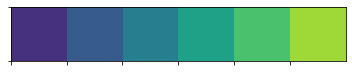

In [5]:
len(sns.color_palette('viridis'))
sns.palplot(sns.color_palette('viridis'))

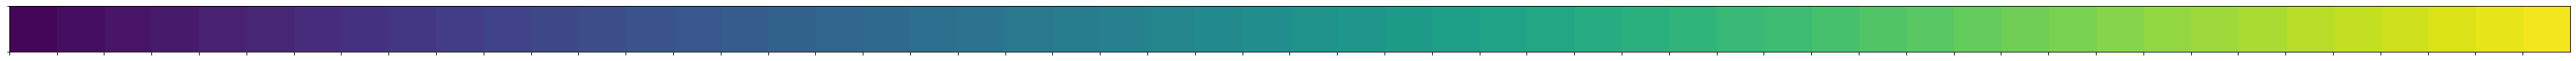

In [6]:
cmap = sns.color_palette('viridis', n_colors = len(ati))
sns.palplot(cmap)
cols = [cmap[0], cmap[int(len(cmap)/2)], cmap[-1]]

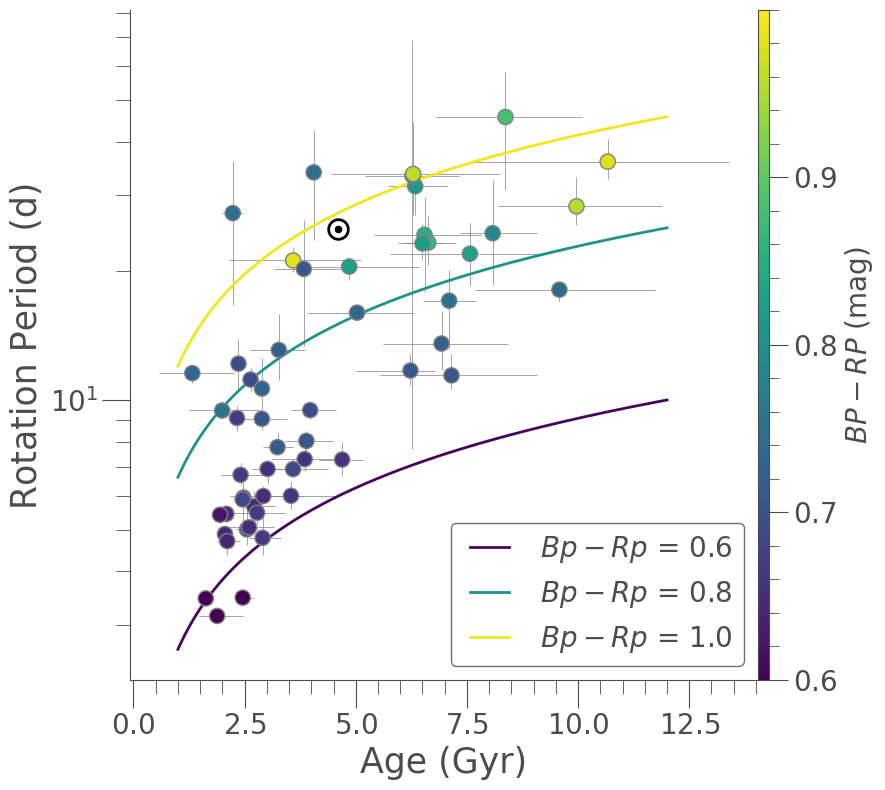

In [25]:
with plt.style.context(mystyle.ps):
    sns.set_palette(cmap)
    fig, ax = plt.subplots(figsize=(9,8))
    c = ax.scatter(ati.age, ati.P, lw=1, ec='grey', c=ati.bprp,
                   vmin=0.6, vmax=1., s=120, zorder=2)
    plt.errorbar(ati.age, ati.P, xerr=[ati.loage, ati.upage], yerr=[ati.l_P, ati.u_P],
                fmt='|', zorder=1, color='grey')

    tau = np.linspace(1., 12., 200)
    for idx, col in enumerate([0.6, 0.8, 1.]):
        plt.plot(tau, gyro(tau, col, *ours), label=r'$Bp-Rp$ = {:.1f}'.format(col), 
                 lw=2, ls='-', zorder=1, c=cols[idx])

    plt.scatter(sun['age'],sun['P'], s=200, c='white', ec='k',lw=2)
    plt.scatter(sun['age'],sun['P'], s=20, c='k')

    ax.set_axisbelow(True)
    ax.set_xlabel('Age (Gyr)')
    ax.set_ylabel('Rotation Period (d)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='lower right', fontsize=20)
    ax.set_yscale('log')

    cb = fig.colorbar(c, cmap=cmap, pad=0,
                 ticks=[0.6, 0.7, 0.8, 0.9],aspect=60)
    cb.ax.tick_params(labelsize=20, length=14)
    cb.ax.tick_params(which='minor', length=7)
    cb.set_label(r'$BP-RP$ (mag)', fontsize=20)

    
    fig.tight_layout()
    plt.savefig('PvAge.pdf')
    plt.show()

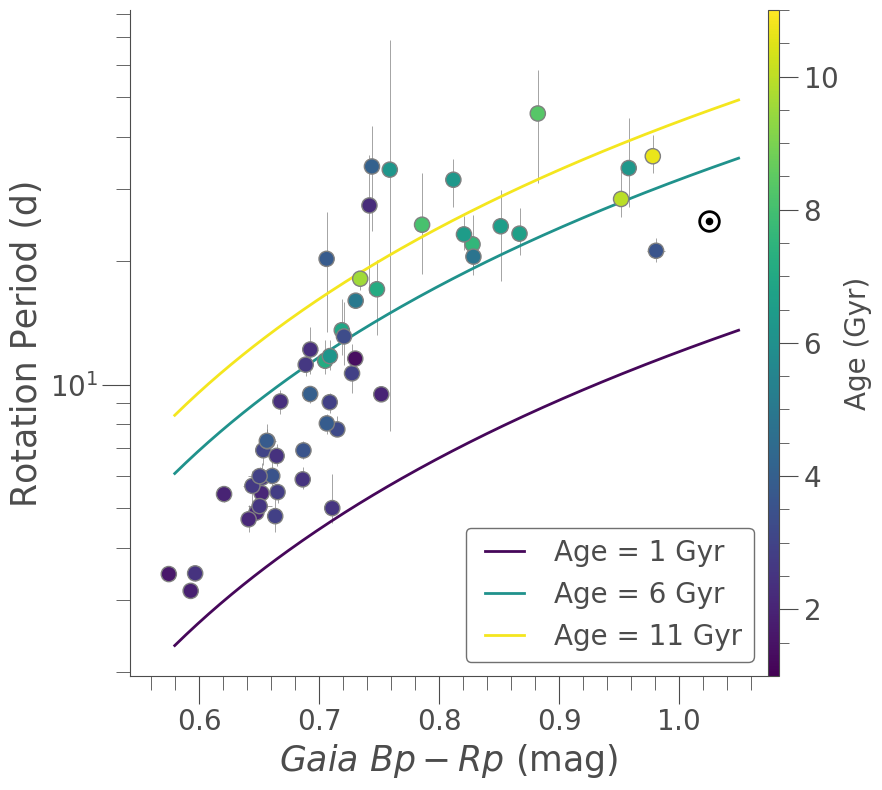

In [26]:
with plt.style.context(mystyle.ps):
    sns.set_palette(cmap)
    fig, ax = plt.subplots(figsize=(9,8))
    c = ax.scatter(ati.bprp, ati.P, lw=1, ec='grey', c=ati.age, 
                   vmin=1, vmax=11, cmap='viridis', s=120, zorder=2)
    plt.errorbar(ati.bprp, ati.P, xerr=ati.ebprp, yerr=[ati.l_P, ati.u_P],
                fmt='|', zorder=1, color='grey')

    col = np.linspace(0.58, 1.05, 200)
    for idx, tau in enumerate([1., 6., 11.]):
        plt.plot(col, gyro(tau, col, *ours), label=r'Age = {:.0f} Gyr'.format(tau), 
                 lw=2, ls='-', zorder=1, c=cols[idx])

    plt.scatter(sun['bprp'],sun['P'], s=200, c='white', ec='k',lw=2,zorder=3)
    plt.scatter(sun['bprp'],sun['P'], s=20, c='k',zorder=3)

    ax.set_axisbelow(True)
    ax.set_xlabel(r'$Gaia$ $Bp-Rp$ (mag)')
    ax.set_ylabel('Rotation Period (d)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yscale('log')
    ax.legend(loc='lower right', fontsize=20)
    
    cb = fig.colorbar(c, pad=0,aspect=60)
    cb.ax.tick_params(labelsize=20, length=14)
    cb.ax.tick_params(which='minor', length=7)
    cb.set_label('Age (Gyr)', fontsize=20)
    
    
    fig.tight_layout()
    plt.savefig('PvCol.pdf')
    plt.show()



# Predicted Period plots

In [27]:
bv = pd.read_csv('../data/simbad_colours.txt',index_col=0, sep='|')
bv['KIC'] = [int(str(kic)[4:]) for kic in bv['KIC'].values]
bv.loc[bv['B'] == -99] = np.nan
bv.loc[bv['V'] == -99] = np.nan
bv['BV'] = bv.B - bv.V
bv = bv[['KIC','BV']]

kal = pd.merge(ati, bv, how='left', on='KIC')
kal = kal[np.isfinite(kal.BV.values)]
print('We have {} stars'.format(len(kal)))

We have 52 stars


In [28]:
def gyro(tau, bv, a, b, c, d):
    lnP = a * np.log(tau*1000) + np.log(b) + d*np.log(bv - c)
    return np.exp(lnP)

In [29]:
angus = [0.55, 0.40, 0.45, 0.31]
Ppred = gyro(kal.age, kal.BV, *angus)
sun['Ppred'] = gyro(sun['age'], sun['BV'], *angus)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [49]:
from uncertainties import ufloat
kal['ratio'] = Ppred / kal.P
sun['ratio'] = sun['Ppred']/sun['P']
kal['u_ratio'] = (Ppred / kal.P**2) * kal.u_P
kal['l_ratio'] = (Ppred / kal.P**2) * kal.l_P

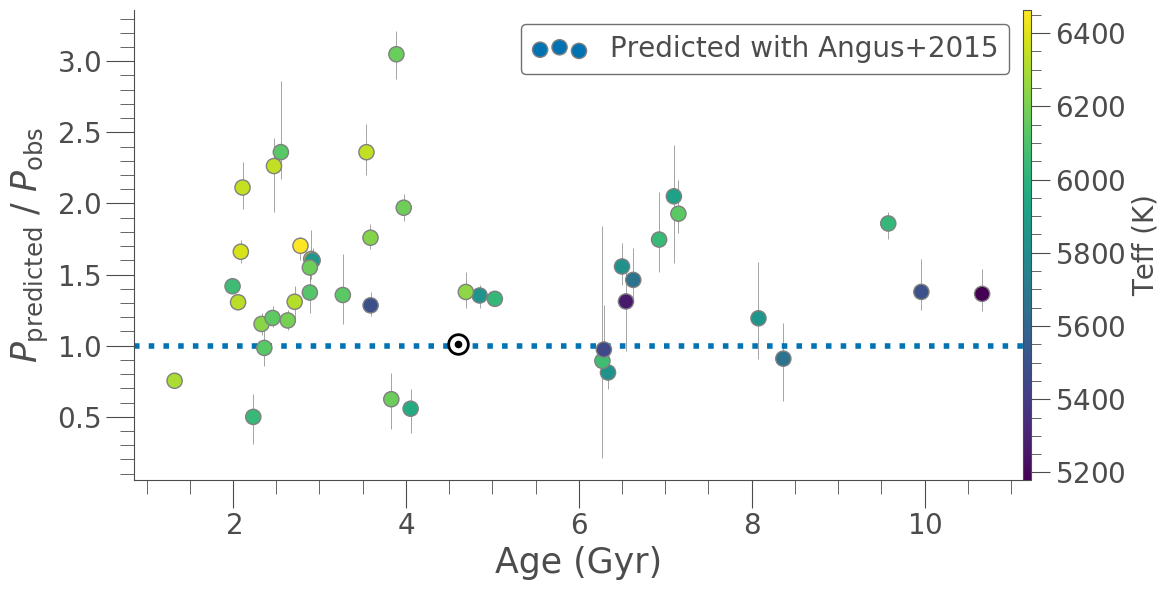

In [34]:
with plt.style.context(mystyle.ps):
    sns.set_palette('colorblind')
    fig, ax = plt.subplots(figsize=(12,6))
    c = ax.scatter(kal.age,  ratio, lw=1, ec='grey', c=kal.Teff,s=120, zorder=2,
                  label='Predicted with Angus+2015')
    ax.errorbar(kal.age, ratio, yerr=[l_ratio, u_ratio],
                fmt='|', zorder=1, color='grey')

 
    ax.scatter(sun['age'],sun['ratio'], s=200, c='white', ec='k',lw=2,zorder=3)
    ax.scatter(sun['age'],sun['ratio'], s=20, c='k',zorder=3)

    ax.axhline(1., ls=':', lw=4, zorder=1)
    
    ax.set_axisbelow(True)
    ax.set_xlabel(r'Age (Gyr)')
    ax.set_ylabel(r'$P_{\rm predicted}$ / $P_{\rm obs}$')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='upper right', fontsize=20)
    
    cb = fig.colorbar(c, pad=0,aspect=60)
    cb.ax.tick_params(labelsize=20, length=14)
    cb.ax.tick_params(which='minor', length=7)
    cb.set_label('Teff (K)', fontsize=20)
    
    fig.tight_layout()
    plt.savefig('PvPred.pdf')
    plt.show()



a. 5900-6200 K, b. 5600-5900 K, c. 5100-5400 K

In [95]:
z = kal.loc[(kal.Teff > 6200)]
a = kal.loc[(kal.Teff > 5900)&(kal.Teff < 6200)]
b = kal.loc[(kal.Teff > 5600)&(kal.Teff < 5900)]
c = kal.loc[(kal.Teff > 5100)&(kal.Teff < 5400)]

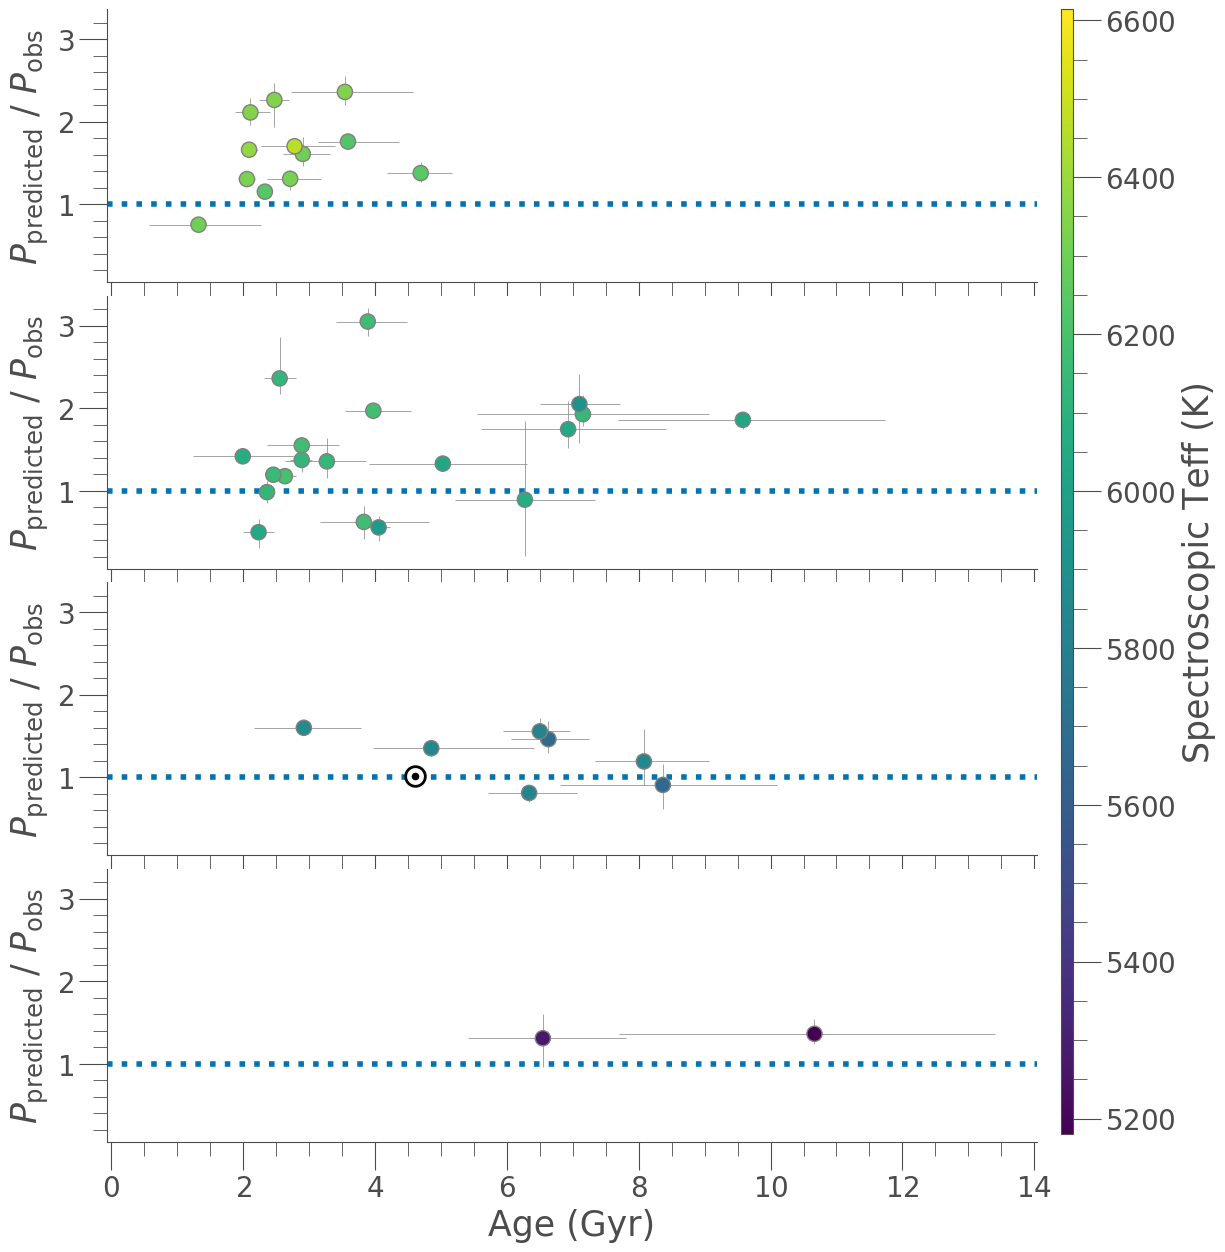

In [105]:
with plt.style.context(mystyle.ps):
    sns.set_palette('colorblind')
    fig, ax = plt.subplots(4, sharex=True, sharey=True, figsize=(12,15))
    col = ax[0].scatter(z.age,  z.ratio, lw=1, ec='grey', c=z.Teff,s=120, zorder=2,
                     vmin = kal.Teff.min(), vmax=kal.Teff.max())
    ax[0].errorbar(z.age, z.ratio, yerr=[z.l_ratio, z.u_ratio], xerr=[z.loage, z.upage],
                fmt='|', zorder=1, color='grey')    
    
    col = ax[1].scatter(a.age,  a.ratio, lw=1, ec='grey', c=a.Teff,s=120, zorder=2,
                     vmin = kal.Teff.min(), vmax=kal.Teff.max())
    ax[1].errorbar(a.age, a.ratio, yerr=[a.l_ratio, a.u_ratio], xerr=[a.loage, a.upage],
                fmt='|', zorder=1, color='grey')
    
    col = ax[2].scatter(b.age,  b.ratio, lw=1, ec='grey', c=b.Teff,s=120, zorder=2,
                     vmin = kal.Teff.min(), vmax=kal.Teff.max())
    ax[2].errorbar(b.age, b.ratio, yerr=[b.l_ratio, b.u_ratio], xerr=[b.loage, b.upage],
                fmt='|', zorder=1, color='grey')
    
    col = ax[3].scatter(c.age,  c.ratio, lw=1, ec='grey', c=c.Teff,s=120, zorder=2,
                     vmin = kal.Teff.min(), vmax=kal.Teff.max())
    ax[3].errorbar(c.age, c.ratio, yerr=[c.l_ratio, c.u_ratio], xerr=[c.loage, c.upage],
                fmt='|', zorder=1, color='grey')    

    ax[2].scatter(sun['age'],sun['ratio'], s=200, c='white', ec='k',lw=2,zorder=3)
    ax[2].scatter(sun['age'],sun['ratio'], s=20, c='k',zorder=3)

    ax[0].axhline(1., ls=':', lw=4, zorder=1)
    ax[1].axhline(1., ls=':', lw=4, zorder=1)
    ax[2].axhline(1., ls=':', lw=4, zorder=1)   
    ax[3].axhline(1., ls=':', lw=4, zorder=1)

    ax[3].set_xlabel(r'Age (Gyr)')
    ax[0].set_ylabel(r'$P_{\rm predicted}$ / $P_{\rm obs}$')
    ax[1].set_ylabel(r'$P_{\rm predicted}$ / $P_{\rm obs}$')
    ax[2].set_ylabel(r'$P_{\rm predicted}$ / $P_{\rm obs}$')
    ax[3].set_ylabel(r'$P_{\rm predicted}$ / $P_{\rm obs}$')
    
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[3].spines['right'].set_visible(False)
    ax[3].spines['top'].set_visible(False)    
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['top'].set_visible(False)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.13, 0.01, .75])
    fig.colorbar(col, cax=cbar_ax, label='Spectroscopic Teff (K)')

    
#     fig.tight_layout()
    plt.subplots_adjust(hspace=0.05)
#     plt.savefig('PvPred.pdf')
    plt.show()



# Mass comparison plots

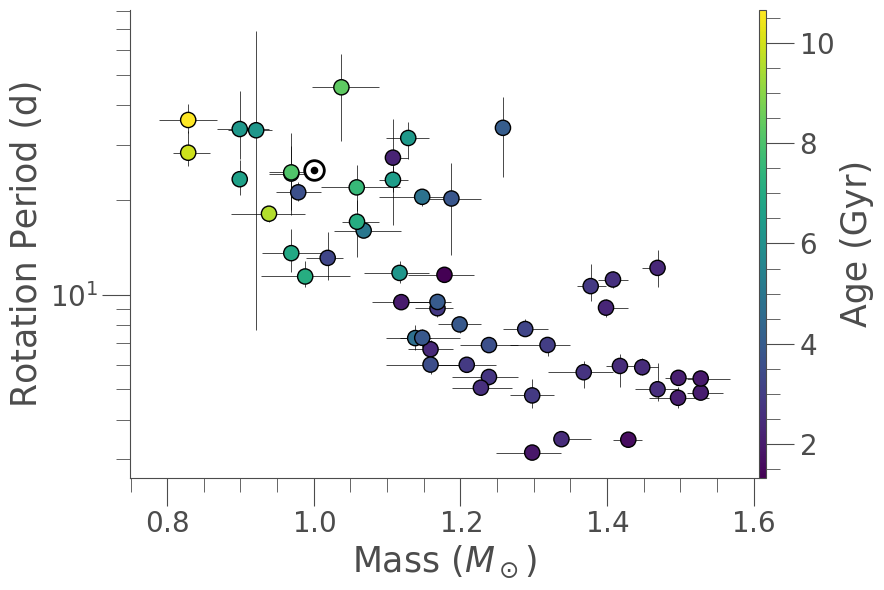

In [39]:
with plt.style.context(mystyle.ps):
    sns.set_palette('viridis')
    fig, ax = plt.subplots(figsize=(9,6))
    c = ax.scatter(ati.modmass, ati.P, lw=1, ec='k', c=ati.age, cmap='viridis', s=120, zorder=2)
    plt.errorbar(ati.modmass, ati.P, xerr=[ati.lomodmass, ati.upmodmass], yerr=[ati.l_P, ati.u_P],
                fmt='|', zorder=1, color='k')

    plt.scatter(sun['M'],sun['P'], s=200, c='white', ec='k',lw=2)
    plt.scatter(sun['M'],sun['P'], s=20, c='k')

    ax.set_axisbelow(True)
    ax.set_xlabel(r'Mass ($M_\odot$)')
    ax.set_ylabel('Rotation Period (d)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#     ax.legend(loc='lower right', fontsize=20)
    ax.set_yscale('log')
    

    cb = fig.colorbar(c,label=r'Age (Gyr)', aspect=60, pad=0)
    
    fig.tight_layout()

    plt.show()



# Rossby Diagram

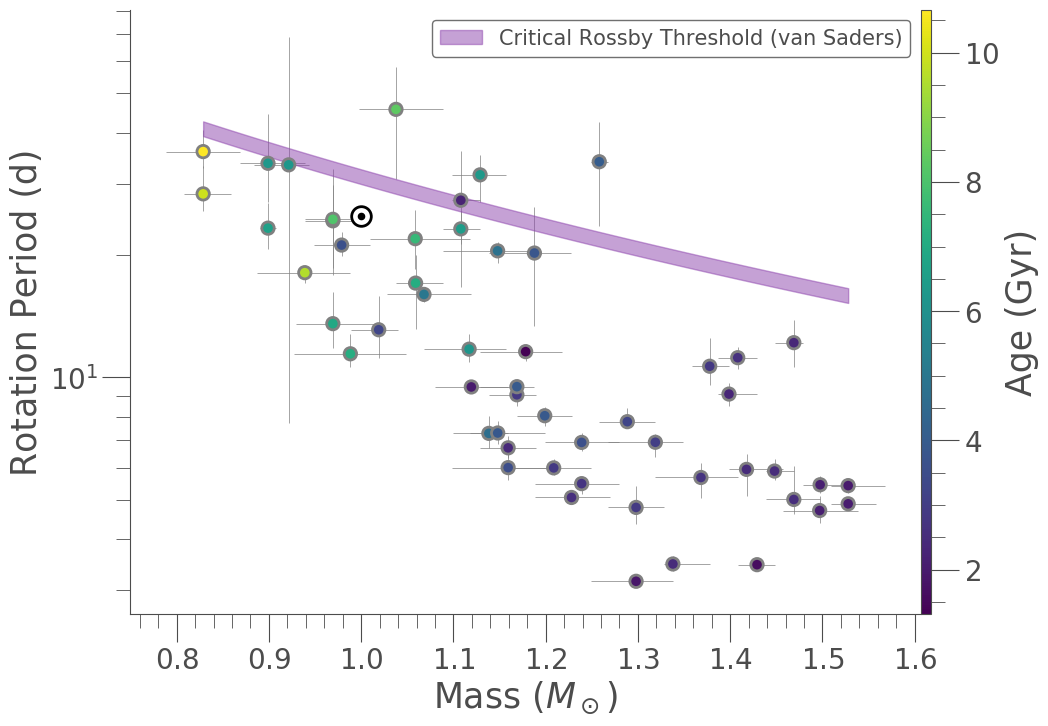

In [109]:
M = np.linspace(ati.modmass.min(), ati.modmass.max(), 100)
tcv = 10**(1.16 - 1.49*np.log10(M) - 0.54*np.log10(M)**2)

with plt.style.context(mystyle.ps):
    fig, ax = plt.subplots(figsize=(12,8))
    c = ax.scatter(ati.modmass, ati.P, lw=2, ec='grey', c=ati.age,s=80, zorder=2)
    plt.errorbar(ati.modmass, ati.P, xerr=[ati.lomodmass, ati.upmodmass], yerr=[ati.l_P, ati.u_P],
                fmt='|', zorder=1, color='grey')

    plt.fill_between(M, (2.16+0.09) * tcv, (2.16-0.09) * tcv, color='#8d44ad', alpha=.5, label='Critical Rossby Threshold (van Saders)')
    
    plt.scatter(sun['M'],sun['P'], s=200, c='white', ec='k',lw=2)
    plt.scatter(sun['M'],sun['P'], s=20, c='k')

    ax.set_axisbelow(True)
    ax.set_xlabel(r'Mass ($M_\odot$)')
    ax.set_ylabel('Rotation Period (d)')
    ax.set_yscale('log')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    fig.colorbar(c, label='Age (Gyr)',aspect=60, pad=0)
    ax.legend(loc='best',fontsize=15)
    plt.show()

# Kiel Diagram

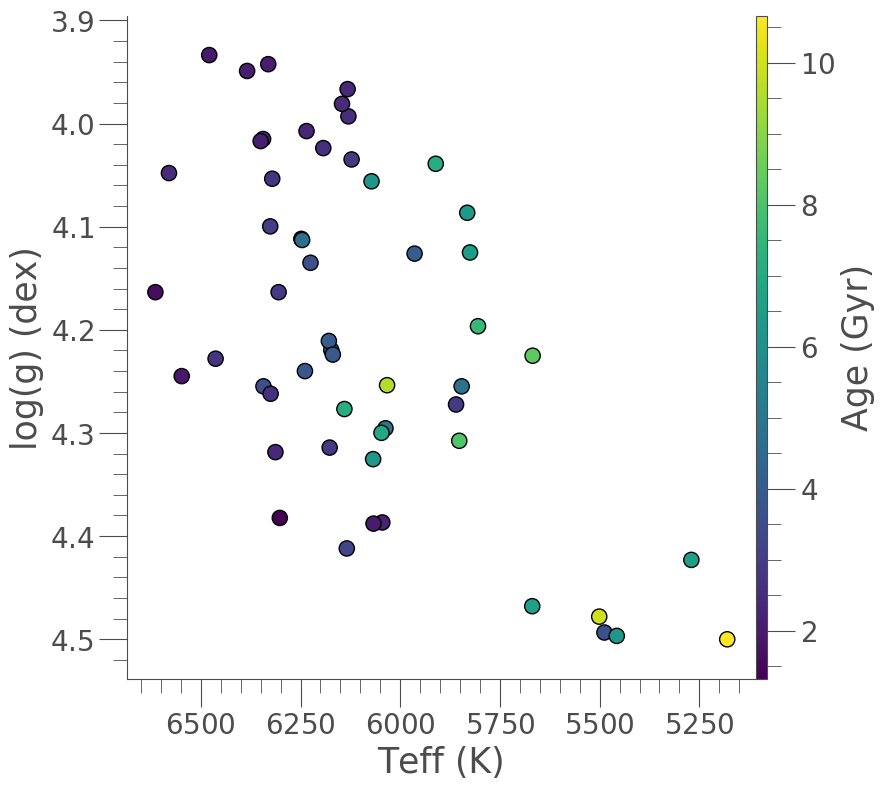

In [44]:
with plt.style.context(mystyle.ps):
    sns.set_palette('viridis')
    fig, ax = plt.subplots(figsize=(9,8))
    c = ax.scatter(ati.Teff, ati.modlogg, lw=1, ec='k', c=ati.age, cmap='viridis', s=120, zorder=2)
    plt.errorbar(ati.Teff, ati.modlogg,
                fmt='|', zorder=1, color='k')

    ax.set_axisbelow(True)
    ax.set_xlabel('Teff (K)')
    ax.set_ylabel('log(g) (dex)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.colorbar(c,label=r'Age (Gyr)', aspect=60, pad=0)

    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    fig.tight_layout()
    plt.show()



Balona paper

# Seismo plots

In [14]:
def epsilon( i, l, m):
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6

def lor(f, freq, h, w):
    return h / (1.0 + 4.0/w**2*(f - freq)**2)


Simulated data

In [15]:
locs = np.genfromtxt('../code/scripts/locs.txt')
pp = np.genfromtxt('../code/scripts/model.txt')
ff = np.genfromtxt('../code/scripts/freqs.txt')
lws = np.genfromtxt('../code/scripts/lws.txt')

In [16]:
import astropy.units as u
nus = (1./u.Quantity(10, u.day)).to(u.microhertz).value
i = np.deg2rad(45.)
d02 = 6.8
dnu = 102.
numax = 2200.

In [17]:
loc = locs[3,1]
lw = lws[3,1]
f = ff[(ff > loc-.03*dnu) & (ff < loc+.03*dnu)]


In [18]:
m0 = lor(f, loc, epsilon(i, 1, 0), lw)
m1 = lor(f, loc+nus, epsilon(i, 1, 1), lw)
mm1 = lor(f, loc-nus, epsilon(i, 1, -1), lw)

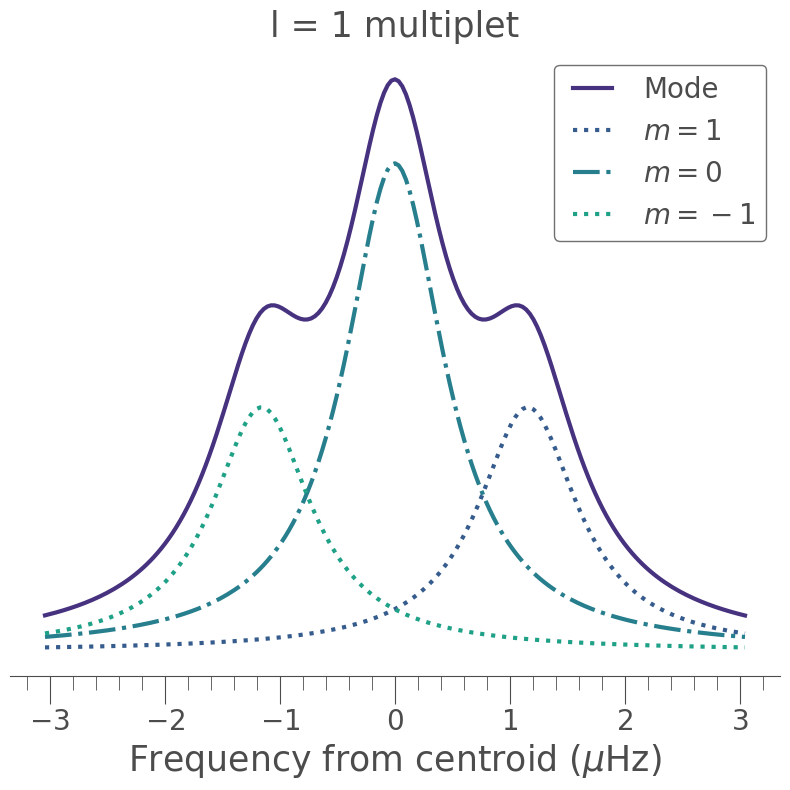

In [19]:
with plt.style.context(mystyle.ps):
    sns.set_palette('viridis')
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    
    ax.plot(f-loc, m0 + m1 + mm1, lw=3, label=r'Mode')
    ax.plot(f-loc, m1, lw=3, ls=':', label=r'$m = 1$')
    ax.plot(f-loc, m0, lw=3, ls='-.', label=r'$m = 0$')
    ax.plot(f-loc, mm1, lw=3, ls=':', label=r'$m = -1$')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.legend()
    ax.set_xlabel(r'Frequency from centroid ($\mu \rm{Hz}$)')
    ax.set_title('l = 1 multiplet')
    ax.set_yticks([])
    fig.tight_layout()
    plt.savefig('l1modes.pdf')

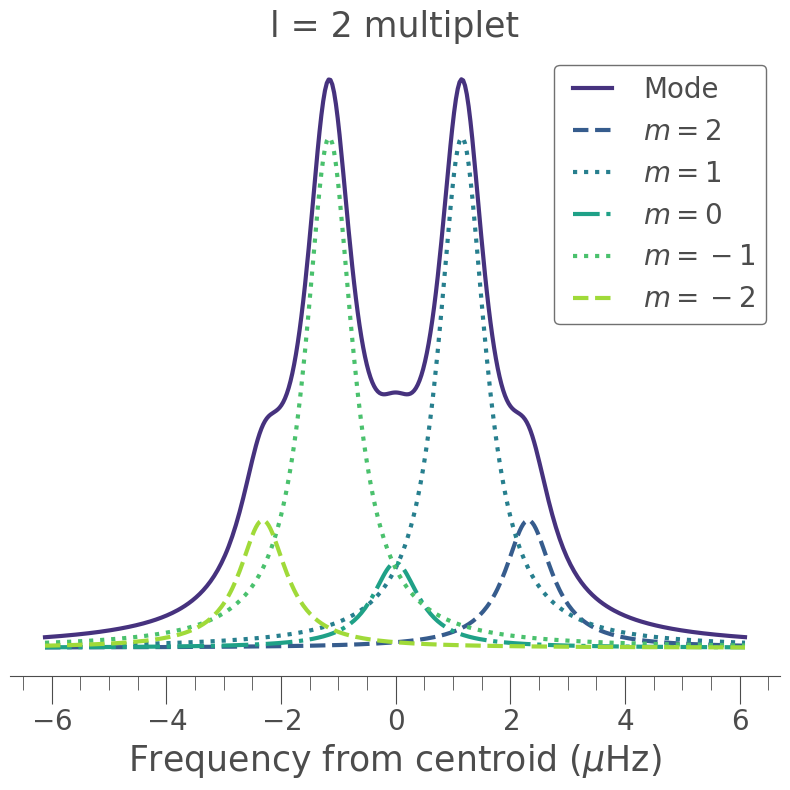

In [20]:
loc = locs[3,2]
lw = lws[3,2]
f = ff[(ff > loc-.06*dnu) & (ff < loc+.06*dnu)]

m0 = lor(f, loc, epsilon(i, 2, 0), lw)
m1 = lor(f, loc+nus, epsilon(i, 2, 1), lw)
mm1 = lor(f, loc-nus, epsilon(i, 2, -1), lw)
m2 = lor(f, loc+2*nus, epsilon(i, 2, 2), lw)
mm2 = lor(f, loc-2*nus, epsilon(i, 2, -2), lw)

with plt.style.context(mystyle.ps):
    sns.set_palette('viridis')
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    
    ax.plot(f-loc, m0 + m1 + mm1 + m2 + mm2, lw=3, label=r'Mode')
    ax.plot(f-loc, m2, lw=3, ls='--', label=r'$m = 2$')
    ax.plot(f-loc, m1, lw=3, ls=':', label=r'$m = 1$')
    ax.plot(f-loc, m0, lw=3, ls='-.', label=r'$m = 0$')
    ax.plot(f-loc, mm1, lw=3, ls=':', label=r'$m = -1$')
    ax.plot(f-loc, mm2, lw=3, ls='--', label=r'$m = -2$')

    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.legend(loc='upper right')
    ax.set_title('l = 2 multiplet')
    ax.set_xlabel(r'Frequency from centroid ($\mu \rm{Hz}$)')
    ax.set_yticks([])
    fig.tight_layout()
    plt.savefig('l2modes.pdf')